# 1. Найти и подготовить данные для задачи классификации или регрессии

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import LabelBinarizer



df = pd.read_csv('miami-housing.csv', sep=',')
df.head()

# Выбираем числовые столбцы для дальнейшей обработки
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Инициализация стандартизатора (StandardScaler)
scaler = StandardScaler()

# Применяем стандартизацию к числовым столбцам (преобразуем данные так, чтобы у них был средний = 0 и стандартное отклонение = 1)
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_columns]), columns=numeric_columns)

# Отображение первых строк стандартизированных данных
df_scaled.head()

,LATITUDE,LONGITUDE,PARCELNO,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,1.153532,1.871328,-1.446087,0.126285,0.124240,-0.374974,-0.688421,-0.895569,-1.073043,-0.973193,-0.802161,-0.152197,1.356321,1.717578,-0.123109,0.407151,0.442866
1,1.155620,1.945244,-1.446087,-0.160597,0.124240,-0.421685,-0.688421,-0.645771,-1.195979,-0.974014,-0.780616,-0.170324,1.713909,1.528474,-0.123109,0.710053,0.442866
2,1.155690,1.947800,-1.446087,1.261204,0.124240,0.267920,2.854008,-0.637063,-1.200202,-0.977425,-0.779819,-0.170856,1.726350,1.433921,-0.123109,-1.410257,0.442866
3,1.158752,1.959935,-1.446087,1.853884,0.630840,-0.000055,0.033873,-0.609205,-1.223937,-1.002323,-0.771474,-0.166592,1.778074,1.528474,-0.123109,0.710053,0.442866
4,1.159178,1.937710,-1.446087,1.119339,0.688502,-0.459791,0.512474,-0.693636,-1.185271,-0.974953,-0.777654,-0.160834,1.677394,0.535674,-0.123109,0.104250,0.442866


# 2. Построить дерево решений:

Среднеквадратичная ошибка для задачи регрессии (Decision Tree): 22612281653.31
Точность для задачи классификации (Decision Tree): 0.81


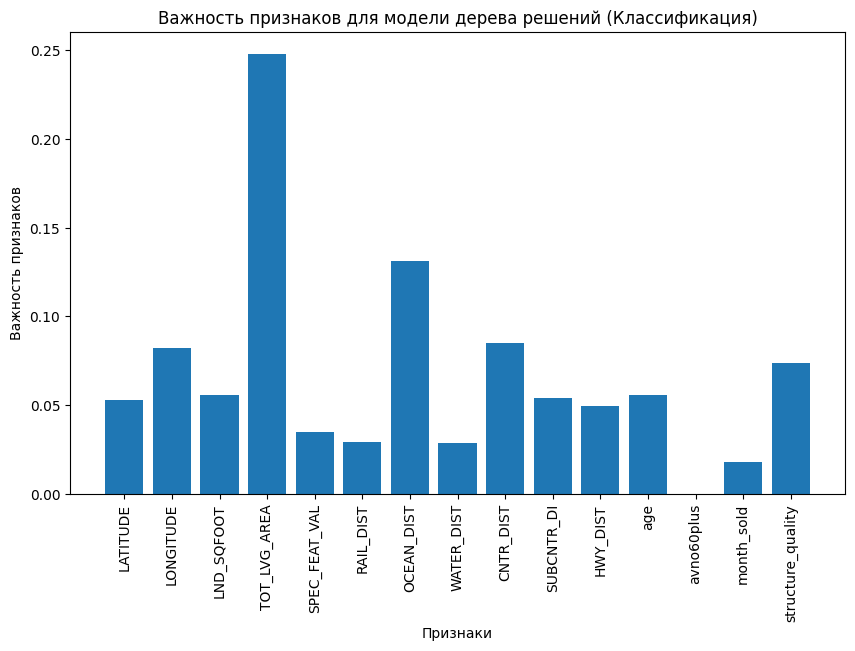

In [ ]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Предобработка данных - удаление ненужных столбцов и разделение признаков и целевой переменной
X = df.drop(columns=['SALE_PRC', 'PARCELNO'])  # Убираем целевую переменную и уникальный идентификатор
y_regression = df['SALE_PRC']  # Целевая переменная для регрессии

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.3, random_state=42)

# Дерево решений для задачи регрессии
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train_reg)

# Предсказание и оценка MSE для регрессии
y_pred_reg = regressor.predict(X_test)
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f"Среднеквадратичная ошибка для задачи регрессии (Decision Tree): {mse:.2f}")

# Для классификации создадим новую категориальную целевую переменную на основе цены
df['price_category'] = pd.qcut(df['SALE_PRC'], q=3, labels=['low', 'medium', 'high'])
y_classification = df['price_category']  # Целевая переменная для классификации

# Разделение данных на обучающую и тестовую выборки для классификации
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=0.3, random_state=42)

# Дерево решений для задачи классификации
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train_class, y_train_class)

# Предсказание и оценка точности для классификации
y_pred_class = classifier.predict(X_test_class)
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"Точность для задачи классификации (Decision Tree): {accuracy:.2f}")

# Визуализация важности признаков для классификации
importances = classifier.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(x=X.columns, height=importances)
plt.xlabel('Признаки')
plt.ylabel('Важность признаков')
plt.title('Важность признаков для модели дерева решений (Классификация)')
plt.xticks(rotation=90)
plt.show()


# 3. Подобрать гиперпараметры дерева решений:

In [ ]:

# Определение параметров для GridSearchCV для классификации
param_grid_class = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV для классификации
grid_search_class = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_class, cv=5, scoring='f1_weighted')
grid_search_class.fit(X_train_class, y_train_class)

# Лучшая модель классификации и оценка её качества
best_classifier = grid_search_class.best_estimator_
y_pred_class = best_classifier.predict(X_test_class)
f1 = f1_score(y_test_class, y_pred_class, average='weighted')
accuracy = accuracy_score(y_test_class, y_pred_class)

print(f"Лучшие гиперпараметры для классификации: {grid_search_class.best_params_}")
print(f"Точность для классификации: {accuracy:.2f}")
print(f"F1-Score для классификации: {f1:.2f}")



Лучшие гиперпараметры для классификации: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Точность для классификации: 0.82
F1-Score для классификации: 0.82


# 4. Реализовать ансамбли моделей:


In [ ]:
from sklearn.ensemble import BaggingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier

# Бэггинг (Bagging) для классификации
bagging_classifier = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=50, random_state=42)
bagging_classifier.fit(X_train_class, y_train_class)
y_pred_bagging_class = bagging_classifier.predict(X_test_class)
accuracy_bagging = accuracy_score(y_test_class, y_pred_bagging_class)
f1_bagging = f1_score(y_test_class, y_pred_bagging_class, average='weighted')

print(f"\nРезультаты бэггинга для классификации:")
print(f"Точность: {accuracy_bagging:.2f}")
print(f"F1-Score: {f1_bagging:.2f}")

from sklearn.preprocessing import LabelEncoder

# Преобразование категориальных меток в числовые для задачи классификации
label_encoder = LabelEncoder()
y_train_class_encoded = label_encoder.fit_transform(y_train_class)
y_test_class_encoded = label_encoder.transform(y_test_class)

# Бустинг (Boosting) с XGBoost
xgb_classifier = XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.1)
xgb_classifier.fit(X_train_class, y_train_class_encoded)
y_pred_xgb_class = xgb_classifier.predict(X_test_class)

# Преобразование предсказанных значений обратно в оригинальные метки
y_pred_xgb_class_decoded = label_encoder.inverse_transform(y_pred_xgb_class)
accuracy_xgb = accuracy_score(y_test_class, y_pred_xgb_class_decoded)
f1_xgb = f1_score(y_test_class, y_pred_xgb_class_decoded, average='weighted')

print(f"\nРезультаты XGBoost для классификации:")
print(f"Точность: {accuracy_xgb:.2f}")
print(f"F1-Score: {f1_xgb:.2f}")


# Стекинг (Stacking) для классификации
stacking_classifier = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42)),
        ('knn', KNeighborsClassifier())
    ],
    final_estimator=LogisticRegression()
)
stacking_classifier.fit(X_train_class, y_train_class)
y_pred_stacking_class = stacking_classifier.predict(X_test_class)
accuracy_stacking = accuracy_score(y_test_class, y_pred_stacking_class)
f1_stacking = f1_score(y_test_class, y_pred_stacking_class, average='weighted')

print(f"\nРезультаты стекинга для классификации:")
print(f"Точность: {accuracy_stacking:.2f}")
print(f"F1-Score: {f1_stacking:.2f}")



Результаты бэггинга для классификации:
Точность: 0.85
F1-Score: 0.86

Результаты XGBoost для классификации:
Точность: 0.87
F1-Score: 0.87

Результаты стекинга для классификации:
Точность: 0.87
F1-Score: 0.87
